# PyTorch

## Importar librerías

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# PyTorch 
import torch
import torch.nn as nn
import torch.nn.functional as F

## Importar imágenes 

In [3]:
from get_images import get_images

In [4]:
# MNIST path
mnist_path = './mnist_raw/'
x_train_num, y_train_num, x_test_num, y_test_num = get_images(mnist_path)

x_train = x_train_num[:50000].reshape(50000, -1).astype(np.float32)
y_train = y_train_num[:50000].reshape(50000, 1)

x_val = x_train_num[50000:].reshape(10000, -1).astype(np.float)
y_val = y_train_num[50000:].reshape(10000, 1)

x_test = x_test_num.copy().reshape(10000, -1).astype(np.float)
y_test = y_test_num.copy().reshape(10000, 1)

## Normalizar imágenes

In [5]:
def normalise(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

In [6]:
x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

In [7]:
x_train.mean(), x_train.std()

(-3.1638146e-07, 0.99999934)

## Mostrar imágenes 

In [8]:
x_test.shape

(10000, 784)

In [9]:
y_train.shape

(50000, 1)

In [10]:
def plot_number(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

La imagen muestreada representa un: 4


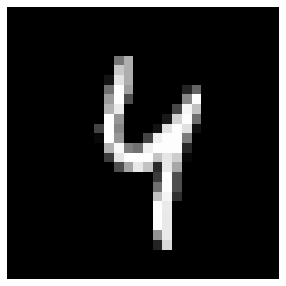

In [11]:
rnd_idx = np.random.randint(len(y_test))
print(f'La imagen muestreada representa un: {y_test[rnd_idx, 0]}')
plot_number(x_test_num[rnd_idx])

## Crear minibatches 

In [12]:
def create_minibatches(x, y, mb_size, shuffle = True):
    '''
    x  #muestras, 784
    y #muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]  
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

## Ahora sí! PyTorch

## Convertir Numpy array a PyTorch 

In [13]:
x_train_tensor = torch.tensor(x_train.copy())
y_train_tensor = torch.tensor(y_train.copy())

x_val_tensor = torch.tensor(x_val.copy())
y_val_tensor = torch.tensor(y_val.copy())

x_test_tensor = torch.tensor(x_test.copy())
y_test_tensor = torch.tensor(y_test.copy())


## Usar GPU de estar disponible

In [14]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Estammos usando: {device}')

Estammos usando: cuda


## Compute accuracy 

In [15]:
def accuracy(model, x, y, mb_size):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in create_minibatches(x, y, mb_size):
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi.squeeze()).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)

            return float(num_correct)/num_total     
            

## Loop de entrenamiento

In [19]:
def train(model, optimiser, mb_size):
    model = model.to(device=device)
#     for epoch in range(epochs):
    acc = 0.0
    epoch = 0
    while acc < 0.95:
        for (xi, yi) in create_minibatches(x_train_tensor, y_train_tensor, mb_size):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)
            # funcion cost
            cost = F.cross_entropy(input= scores, target=yi.squeeze())
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()
        epoch += 1
        acc = accuracy(model, x_val_tensor, y_val_tensor, mb_size)
        print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {acc}')
    

## Modelo usando Sequential

### SGD

In [20]:
#Instanciar modelo
hidden1 = 1000 
hidden = 1000
lr = 1e-2
epochs = 100
mb_size = 4096
model1 = nn.Sequential(nn.Linear(in_features=784, out_features=hidden1), nn.ReLU(),
                       nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
                       nn.Linear(in_features=hidden, out_features=10))
optimiser = torch.optim.SGD(model1.parameters(), lr=lr)

train(model1, optimiser, mb_size)

Epoch: 1, costo: 2.239060640335083, accuracy: 0.35693359375
Epoch: 2, costo: 2.1627449989318848, accuracy: 0.57568359375
Epoch: 3, costo: 2.061123847961426, accuracy: 0.666259765625
Epoch: 4, costo: 1.955766201019287, accuracy: 0.711669921875
Epoch: 5, costo: 1.8481581211090088, accuracy: 0.735107421875
Epoch: 6, costo: 1.7253026962280273, accuracy: 0.756591796875
Epoch: 7, costo: 1.5788172483444214, accuracy: 0.75927734375
Epoch: 8, costo: 1.481008768081665, accuracy: 0.77490234375
Epoch: 9, costo: 1.3326393365859985, accuracy: 0.790771484375
Epoch: 10, costo: 1.21952486038208, accuracy: 0.817626953125
Epoch: 11, costo: 1.086116075515747, accuracy: 0.818603515625
Epoch: 12, costo: 1.0287652015686035, accuracy: 0.834228515625
Epoch: 13, costo: 0.9624242782592773, accuracy: 0.83642578125
Epoch: 14, costo: 0.8743281960487366, accuracy: 0.847900390625
Epoch: 15, costo: 0.816154420375824, accuracy: 0.849365234375
Epoch: 16, costo: 0.7607555985450745, accuracy: 0.856201171875
Epoch: 17, cos

Epoch: 133, costo: 0.285381555557251, accuracy: 0.926513671875
Epoch: 134, costo: 0.26794111728668213, accuracy: 0.926513671875
Epoch: 135, costo: 0.23693063855171204, accuracy: 0.9287109375
Epoch: 136, costo: 0.2476031631231308, accuracy: 0.9267578125
Epoch: 137, costo: 0.24764001369476318, accuracy: 0.93017578125
Epoch: 138, costo: 0.23280031979084015, accuracy: 0.9287109375
Epoch: 139, costo: 0.23762261867523193, accuracy: 0.9296875
Epoch: 140, costo: 0.2655695676803589, accuracy: 0.93115234375
Epoch: 141, costo: 0.2526872456073761, accuracy: 0.9306640625
Epoch: 142, costo: 0.2220446765422821, accuracy: 0.931396484375
Epoch: 143, costo: 0.22616946697235107, accuracy: 0.929931640625
Epoch: 144, costo: 0.24068549275398254, accuracy: 0.92919921875
Epoch: 145, costo: 0.21802373230457306, accuracy: 0.930419921875
Epoch: 146, costo: 0.2677121162414551, accuracy: 0.929931640625
Epoch: 147, costo: 0.2169344574213028, accuracy: 0.94091796875
Epoch: 148, costo: 0.2883422374725342, accuracy: 0

### SGD con Momentum

In [21]:
hidden1 = 1000 
hidden = 1000
lr = 1e-2
epochs = 100
mb_size = 4096
model1 = nn.Sequential(nn.Linear(in_features=784, out_features=hidden1), nn.ReLU(),
                       nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
                       nn.Linear(in_features=hidden, out_features=10))
optimiser = torch.optim.SGD(model1.parameters(), lr=lr, momentum=0.9)

train(model1, optimiser, mb_size)

Epoch: 1, costo: 1.953113317489624, accuracy: 0.6845703125
Epoch: 2, costo: 1.165447473526001, accuracy: 0.793212890625
Epoch: 3, costo: 0.5796141028404236, accuracy: 0.856689453125
Epoch: 4, costo: 0.48198145627975464, accuracy: 0.881103515625
Epoch: 5, costo: 0.3740842938423157, accuracy: 0.89111328125
Epoch: 6, costo: 0.34306246042251587, accuracy: 0.9033203125
Epoch: 7, costo: 0.31623920798301697, accuracy: 0.90625
Epoch: 8, costo: 0.33210045099258423, accuracy: 0.913818359375
Epoch: 9, costo: 0.31997767090797424, accuracy: 0.918701171875
Epoch: 10, costo: 0.31854522228240967, accuracy: 0.91650390625
Epoch: 11, costo: 0.30447497963905334, accuracy: 0.9267578125
Epoch: 12, costo: 0.3108142018318176, accuracy: 0.927734375
Epoch: 13, costo: 0.29545527696609497, accuracy: 0.929931640625
Epoch: 14, costo: 0.29907387495040894, accuracy: 0.931396484375
Epoch: 15, costo: 0.297604501247406, accuracy: 0.929443359375
Epoch: 16, costo: 0.2387734204530716, accuracy: 0.930908203125
Epoch: 17, co

### RMSProp

In [22]:
hidden1 = 1000 
hidden = 1000
lr = 1e-2
epochs = 100
mb_size = 4096
model1 = nn.Sequential(nn.Linear(in_features=784, out_features=hidden1), nn.ReLU(),
                       nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
                       nn.Linear(in_features=hidden, out_features=10))
optimiser = torch.optim.RMSprop(model1.parameters(), lr=lr, alpha=0.9)

train(model1, optimiser, mb_size)

Epoch: 1, costo: 0.6433298587799072, accuracy: 0.790283203125
Epoch: 2, costo: 0.434357225894928, accuracy: 0.851318359375
Epoch: 3, costo: 0.24605853855609894, accuracy: 0.92529296875
Epoch: 4, costo: 0.19781841337680817, accuracy: 0.9091796875
Epoch: 5, costo: 0.21203777194023132, accuracy: 0.941162109375
Epoch: 6, costo: 1.5524362325668335, accuracy: 0.72607421875
Epoch: 7, costo: 0.15109224617481232, accuracy: 0.948486328125
Epoch: 8, costo: 1.020281434059143, accuracy: 0.74365234375
Epoch: 9, costo: 0.15390509366989136, accuracy: 0.955810546875


### Adam

In [23]:
hidden1 = 1000 
hidden = 1000
lr = 1e-2
epochs = 100
mb_size = 4096
model1 = nn.Sequential(nn.Linear(in_features=784, out_features=hidden1), nn.ReLU(),
                       nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
                       nn.Linear(in_features=hidden, out_features=10))
optimiser = torch.optim.Adam(model1.parameters(), lr=lr, betas=(0.9, 0.999))

train(model1, optimiser, mb_size)

Epoch: 1, costo: 0.5649116635322571, accuracy: 0.850830078125
Epoch: 2, costo: 0.27123522758483887, accuracy: 0.93603515625
Epoch: 3, costo: 0.17298048734664917, accuracy: 0.953369140625
